<div class="alert alert-block alert-success">
    <h1 align="center">SHAP Values</h1>
    <h3 align="center">SHAP (SHapley Additive exPlanations)</h3>
</div>

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.svg">

# What is SHAP Analysis?

If you Google ‘SHAP analysis’, you will find that the term comes from a 2017 paper by Lundberg and Lee, called “A Unified Approach to Interpreting Model Predictions”, which introduces the concept of SHapley Additive exPlanations (SHAP). The goal of SHAP is to explain a machine learning model’s prediction by calculating the contribution of each feature to the prediction.

The technical explanation is that it does this by computing Shapley values from coalitional game theory. Of course, if you’re unfamiliar with game theory and data science, that may not mean much to you. Simply put, Shapely values is a method for showing the relative impact of each feature (or variable) we are measuring on the eventual output of the machine learning model by comparing the relative effect of the inputs against the average.

# SHAP Analysis Explained
Think of buying a second-hand car: You have a particular make and model in mind and a quick search online shows a variety of prices and conditions. In terms of coalitional game theory, the “game” is predicting the price of a specific car. The prediction will have a combination of features, called a “coalition”. The “gain” is the difference between the predicted price for a car against the average predicted price for all combinations of features. The “players” are the feature values that you input into the model which work together to create the gain (or difference from the average value).

Say the average price of your desired car is $20,000. Several factors will move that price up or down for a given vehicle. Age, trim level, condition, and mileage will all influence the price on the vehicle. That’s why it can be difficult to tell if a specific car is priced properly above or below market given all the variables.

Machine learning can solve this problem by building a model to predict what the price should be for a specific vehicle, taking all the variables into account. A SHAP analysis of that model will give you an indication of how significant each factor is in determining the final price prediction the model outputs. It does this by running a large number of predictions comparing the impact of a variable against the other features.

In our example, it’s easy to see that if I look the prices of cars with varying mileage but the same model year, condition and trim level, I can ascertain the impact of mileage on the overall price. SHAP is a bit more complicated since the analysis runs against the varying ‘coalitions’ or combinations of the other variables to get an average impact of the mileage of the car against all possible combinations of features.

In our example, we would end up running a machine learning model varying mileage against all the possible combinations of trim level, model year and condition. Obviously, this means running a lot of combinations through the machine learning model, as the number of combinations grows exponentially with the number of variables you are looking at.

In the used car case, we would have the following coalitions:

    Trim Level
    Mileage
    Model Year
    Condition
    Trim Level + Mileage
    Trim Level + Model Year
    Trim Level + Condition
    Mileage + Model Year
    Mileage + Condition
    Trim Level + Mileage + Model Year
    Trim Level + Model Year + Condition
    Mileage + Trim Level + Condition
    Mileage + Model Year + Condition
    Mileage + Trim Level + Model Year + Condition

In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.1/452.1 kB 44.4 kB/s eta 0:00:0000:0100:01


In [3]:
!pip install sklearn_pandas

In [3]:
import pandas as pd
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")


In [4]:
from sklearn.datasets import load_boston
boston = load_boston()
data = pd.DataFrame(boston.data, columns = boston.feature_names)
data['target'] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
y = data["target"].values
X = data.drop("target" , axis = 1)

In [6]:
print(f"Mean value of median house prices (in $ thousand): {round(y.mean(), 2)}")

Mean value of median house prices (in $ thousand): 22.53


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Linear Regression

In [8]:
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
reg = sm.OLS(y_train, preprocessed_X_train).fit()

In [9]:
def evaluate(X, y, mapper=None, reg=None, transform=False):
    if transform:
        X = mapper.transform(X)
        X = sm.add_constant(X, has_constant='add') 
    y_pred = reg.predict(X)
    return mean_absolute_error(y, y_pred)

In [10]:
train_mae = evaluate(X_train, y_train, mapper, reg, True)
test_mae = evaluate(X_test, y_test, mapper, reg, True)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 3.388, test MAE = 2.52 


In [11]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     97.41
Date:                Fri, 19 Apr 2024   Prob (F-statistic):          1.35e-120
Time:                        17:23:38   Log-Likelihood:                -1361.2
No. Observations:                 455   AIC:                             2750.
Df Residuals:                     441   BIC:                             2808.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7675      0.240     95.013      0.000      22.297      23.238
CRIM          -0.9544      0.316     -3.021      0.003      -1.575      -0.333
ZN             1.1903      0.347      3.426      0.001       0.508       1.873
INDUS          0.2159      0.445      0.485      0.628      -0.659       1.091
NOX           -2.0944      0.505     -4.148      0.000      -3.087      -1.102
RM             2.7612      0.317      8.700      0.000       2.137       3.385
AGE            0.3042      0.411      0.739      0.460      -0.504       1.113
DIS           -3.1207      0.460     -6.788      0.000      -4.024      -2.217
RAD            2.9649      0.678      4.372      0.000       1.632       4.298
TAX           -2.4522      0.715     -3.430      0.001      -3.857      -1.047
PTRATIO       -2.0042      0.310     -6.468      0.000      -2.613      -1.395
B              0.8742      0.272      3.213      0.001       0.339       1.409
LSTAT         -4.0539      0.394    -10.283      0.000      -4.829      -3.279
CHAS           2.5088      0.895      2.804      0.005       0.750       4.267
==============================================================================
Omnibus:                      152.667   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.005
Skew:                           1.474   Prob(JB):                    2.80e-129
Kurtosis:                       7.747   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Random Forest 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = RandomForestRegressor()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

train_mae = evaluate(X_train, y_train, reg=pipeline)
test_mae = evaluate(X_test, y_test, reg=pipeline)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 0.803, test MAE = 2.709 


<BarContainer object of 13 artists>

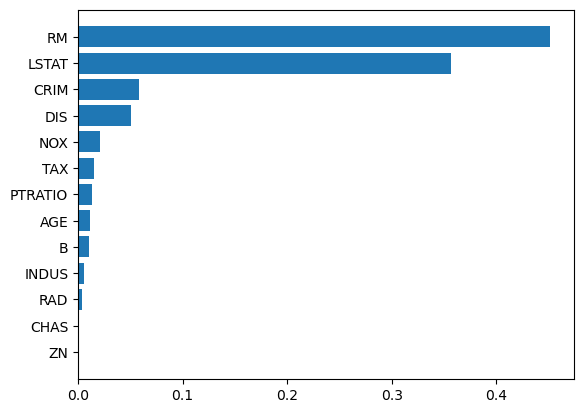

In [13]:
sorted_idx = reg.feature_importances_.argsort()
features = numerical_features + catagorical_features 
result = sorted(zip(features, reg.feature_importances_), key = lambda x: x[1], reverse=False)
plt.barh([x[0] for x in result], [x[1] for x in result])

## Neural Networks

In [14]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim

preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 5454.552459716797
Epoch 10, Loss: 426.9572048187256
Epoch 20, Loss: 220.6321530342102
Epoch 30, Loss: 214.2952013015747
Epoch 40, Loss: 213.18577098846436

train MAE = 3.393, test MAE = 2.5 


We don't have a direct way to identify feature importance for neural networks

## Problems with Interpretation
- No specific method to define feature importance that is model agnostic
- For a given sample, why does the prediction have that value?

Answer: Shap values

## Intuition of Model Interpretation

How we think about answering the question "Why is the output for this specific sample so low/high" manually?

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) #revert
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [SimpleImputer(strategy='constant', fill_value=0),
              OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = LinearRegression()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

In [16]:
nan_frame = pd.DataFrame(columns=catagorical_features+numerical_features, index=[0])
nan_frame

,CHAS,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
base_value = round(pipeline.predict(nan_frame)[0], 3)
print(f"Expected value of the output (base value): {base_value}")

Expected value of the output (base value): 22.767


In [18]:
X_test.iloc[0: 1]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
455,4.75237,0.0,18.1,0.0,0.713,6.525,86.5,2.4358,24.0,666.0,20.2,50.92,18.13


In [19]:
sample_prediction = round(pipeline.predict(X_test.iloc[0: 1])[0], 3)
print(f"Current Prediction: {sample_prediction}, Actual value: {y_test[0]}")

Current Prediction: 15.851, Actual value: 14.1


**How did we get from 22.767 to 15.851?**
- Find this by adjusting individual feature values. But this can be hard to look at
- Fast way to visualize is with Partial Dependency Plots (which uses Shap values for individual samples)
- Shap values assign a contributing factor to every feature of every sample

## Partial Dependence Plots

In [20]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

In [21]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

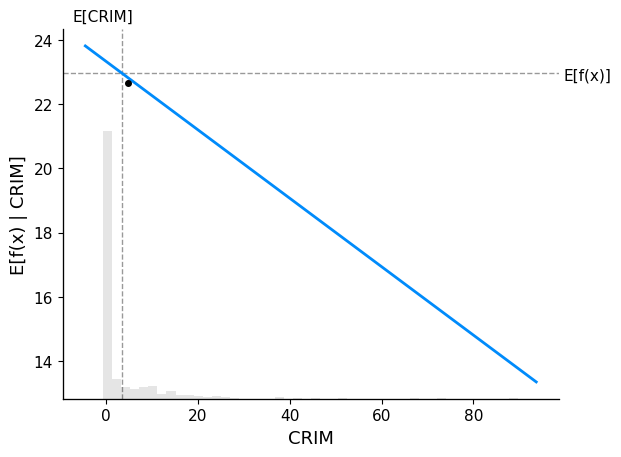

In [22]:
partial_dependence_plot('CRIM', 0)

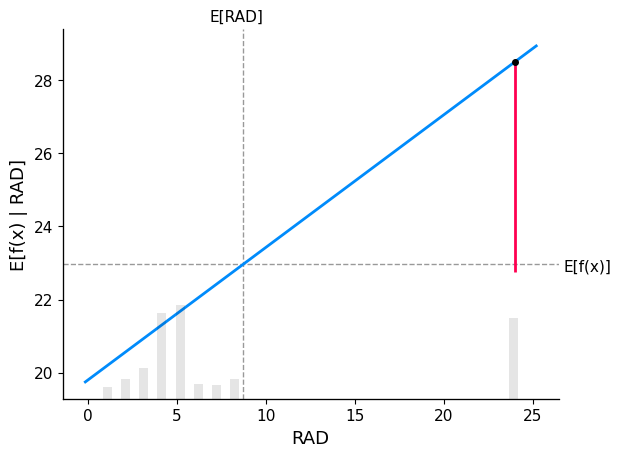

In [25]:
partial_dependence_plot('RAD', 0)

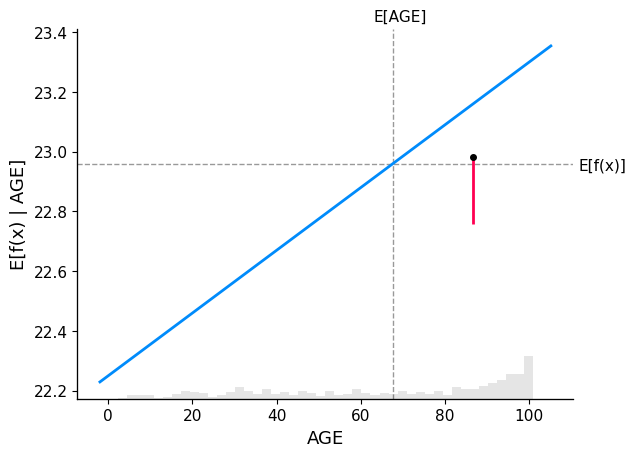

In [26]:
partial_dependence_plot('AGE', 0)

## Shap Plots

Hard to look at every feature for every sample. So lets look at all features of the same sample

In [27]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

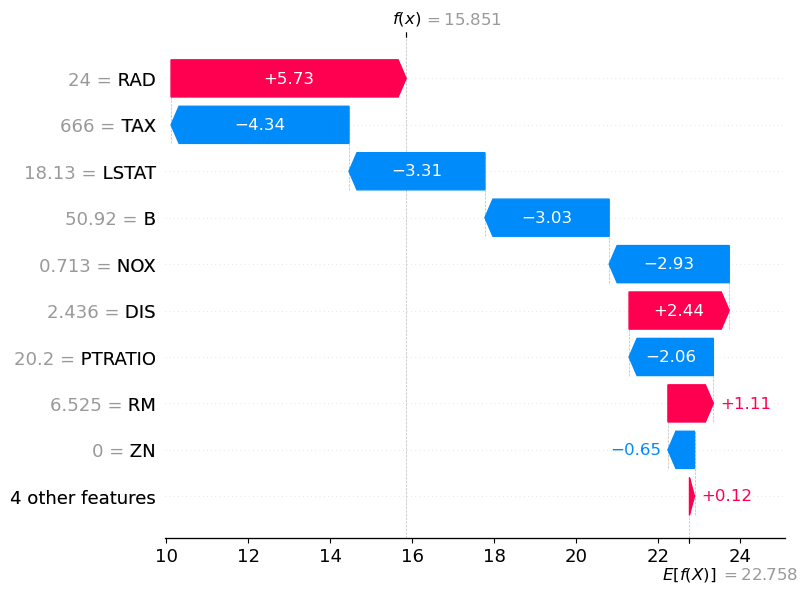

In [28]:
sample_feature_importance(0, 'waterfall')

In [30]:
shap.initjs()

sample_feature_importance(0, 'condensed')

## Feature Importance for model

Looking at individual samples can be a bother. Let's look at all samples together

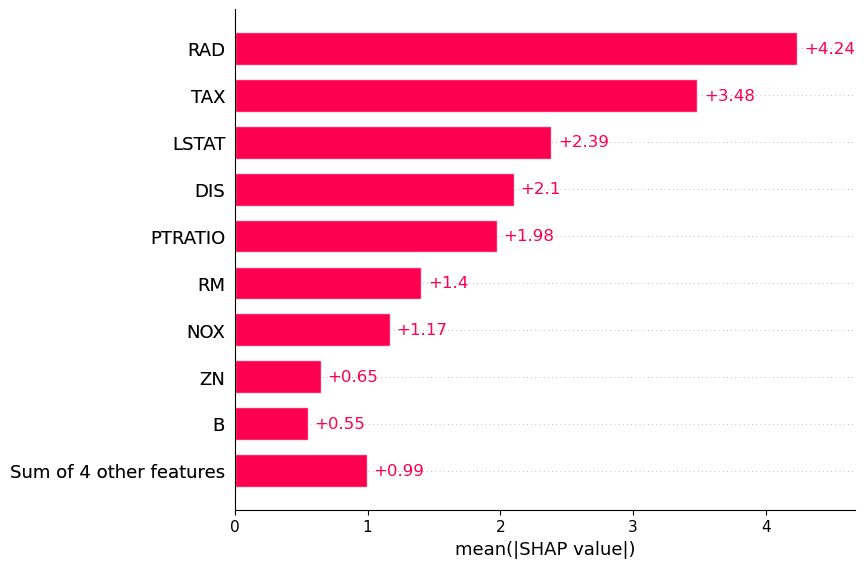

In [31]:
shap.plots.bar(shap_values)

Two most important features according to the LinearRegression model:
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per $10,000

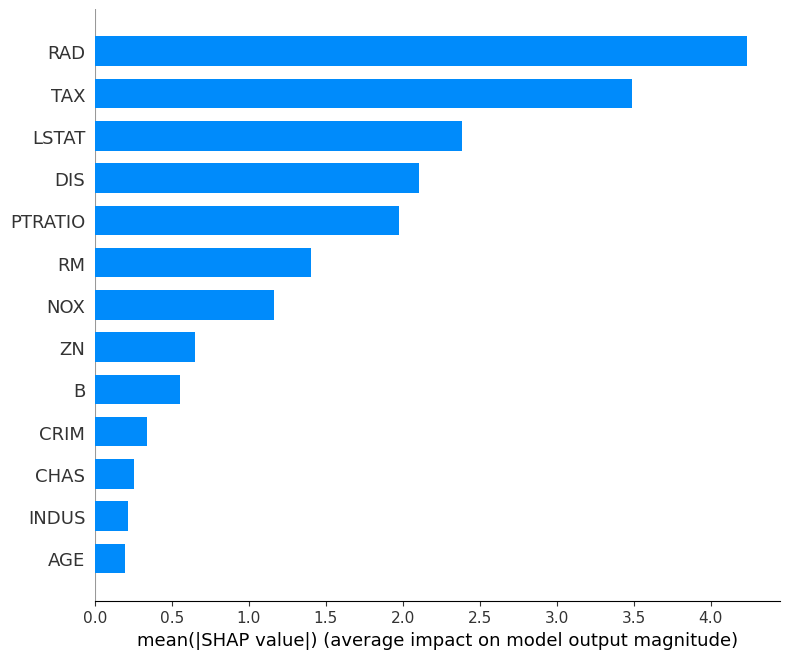

In [32]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

We can interpret the neural network model in the same way

In [33]:
preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 5458.370178222656
Epoch 10, Loss: 367.4732279777527
Epoch 20, Loss: 221.5506362915039
Epoch 30, Loss: 215.27156448364258
Epoch 40, Loss: 213.76006412506104

train MAE = 3.394, test MAE = 2.495 


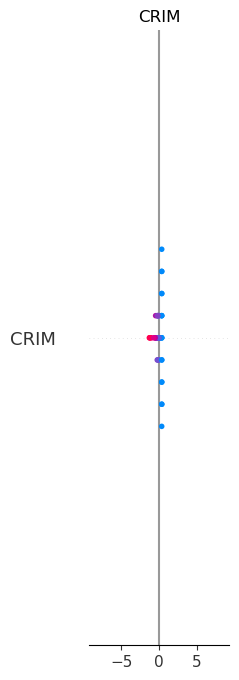

In [34]:
explainer = shap.DeepExplainer(model, torch.from_numpy(preprocessed_X_train.values).float())
shap_values = explainer.shap_values(torch.from_numpy(preprocessed_X_test.values).float())
shap.summary_plot(shap_values, X_test, plot_type='bar')

Most important features for this neural network:
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways

References:
1. https://github.com/slundberg/shap
2. https://acerta.ai/blog/understanding-machine-learning-with-shap-analysis/
3. https://towardsdatascience.com/introduction-to-shap-values-and-their-application-in-machine-learning-8003718e6827
4. https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value-in-detail
5. https://arxiv.org/pdf/1705.07874.pdf